# Predicting Player Goal Counts for the Maple Leafs
___

In [58]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn import linear_model, preprocessing, pipeline, set_config, compose
from sklearn import model_selection, neural_network, metrics
import pickle
set_config(display='diagram')

### Data Preparation
___

In [59]:
# create connection to database
connection = psycopg2.connect(
    host="localhost",
    database="50_in_07",
    user="tanyatang")

In [60]:
# select relevant data from database
cursor = connection.cursor()
cursor.execute(
    """
    WITH data AS (SELECT CONCAT(players.first_name, ' ', players.last_name) as full_name
                       , players.primary_position
                       , players.height
                       , players.weight
                       , teams0.name AS opposing_team
                       , teams2.name AS away_team
                       , teams1.name AS home_team
                       , games.game_type
                       , game_players.assists
                       , game_players.goals
                       , game_players.shots
                       , game_players.time_on_ice
                    FROM games
                    JOIN teams AS teams0
                      ON (games.home_team_id + games.away_team_id - 10) = teams0.id
                    JOIN teams AS teams1
                      ON games.home_team_id = teams1.id
                    JOIN teams AS teams2
                      ON games.away_team_id = teams2.id
                    JOIN game_players
                      ON games.id = game_players.game_id
                    JOIN players
                      ON game_players.player_id = players.id
                   WHERE game_players.team_id = 10
                     AND games.season_id > 20142015)
          SELECT row_to_json(data.*)
            FROM data
    """)
results = cursor.fetchall()
cursor.close()

In [61]:
# close connection
connection.close()

In [62]:
# parse time on ice into seconds and determine home or away status
all_data = list(map(lambda x: x[0], results))
goal_data = list(filter(lambda x: x['time_on_ice'] != '00:00:00', all_data))
for player in goal_data:
    player['height'] = player['height'].split('-')[0] * 12 + player['height'].split('-')[1]
    if player['home_team'] == 'Toronto Maple Leafs':
        player['home_or_away'] = 'Home'
    elif player['away_team'] == 'Toronto Maple Leafs':
        player['home_or_away'] = 'Away'
    else:
        print('Error')
    player.pop('away_team')
    player.pop('home_team')
    player.pop('time_on_ice')

In [63]:
# create pandas dataframe
goal_data = pd.json_normalize(goal_data)
print(goal_data.head(5))

          full_name primary_position         height  weight  \
0  William Nylander       Right Wing  6666666666660     196   
1   Mitchell Marner       Right Wing  6666666666660     175   
2        Zach Hyman        Left Wing  6666666666661     211   
3     Morgan Rielly       Defenseman  6666666666661     219   
4  William Nylander       Right Wing  6666666666660     196   

        opposing_team game_type  assists  goals  shots home_or_away  
0      Buffalo Sabres        PR        0      1      3         Away  
1      Buffalo Sabres        PR        2      0      1         Away  
2  Montreal Canadiens        PR        1      0      2         Home  
3  Montreal Canadiens        PR        0      1      4         Home  
4  Montreal Canadiens        PR        1      0      4         Home  


### Data Visualization
___

In [64]:
# set maplotlib parameters
plt.style.use('ggplot')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = (10, 6)

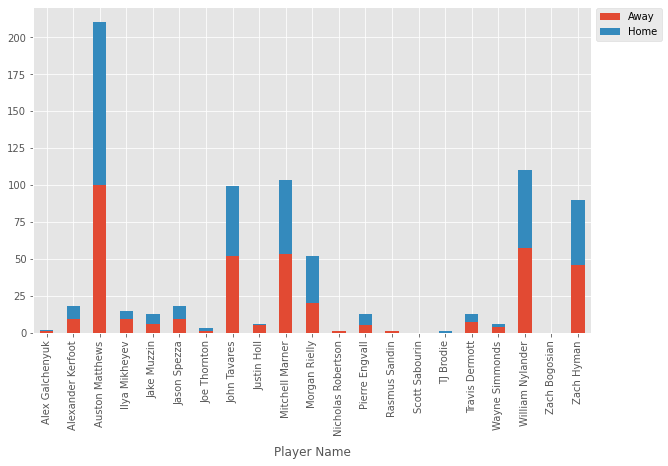

In [65]:
# plot sum of goals per player divided by home or away status
goals_per_player = goal_data.groupby(['full_name', 'home_or_away'])['goals']
ax = goals_per_player.sum().unstack().plot(kind='bar', stacked=True)
ax.set_xlabel('Player Name', labelpad=10)
ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.88))
plt.show()

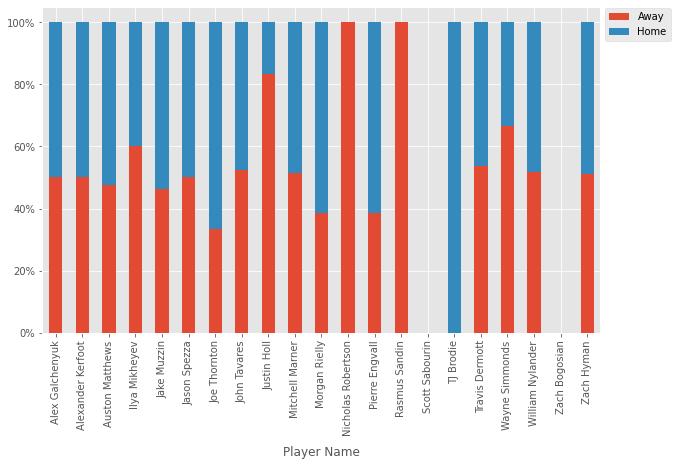

In [66]:
# plot normalized sum of goals per player divided by home or away status
ax = goals_per_player.sum().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar', stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Player Name', labelpad=10)
ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.88))
plt.show()

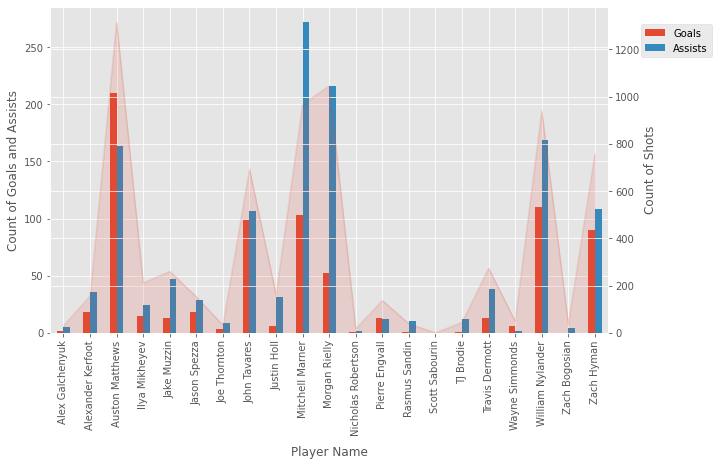

In [67]:
# plot sum of goals per player per opposing team
goals_and_assists_per_player = goal_data.groupby(['full_name'])[['goals', 'assists']]
shots_per_player = goal_data.groupby(['full_name'])['shots']
fig, ax = plt.subplots()
ax1 = ax.twinx()
goals_and_assists_per_player.sum().plot(kind='bar', ax=ax)
ax.set_xlabel('Player Name', labelpad=10)
ax.set_ylabel('Count of Goals and Assists')
ax.legend(['Goals', 'Assists', 'Shots'], loc='lower left', bbox_to_anchor=(1.05, 0.83))
shots_per_player.sum().plot(kind='area', ax=ax1, alpha=0.15)
ax1.set_ylabel('Count of Shots')
plt.show()

### Data Preprocessing
___

In [68]:
# remove unnecessary columns from data
goal_data = goal_data.loc[:, goal_data.columns != 'shots']
goal_data = goal_data.loc[:, goal_data.columns != 'assists']

In [69]:
# separate data into X and y sets
X = goal_data.loc[:, goal_data.columns != 'goals']
y = goal_data['goals']

In [70]:
# encode categorical features
# all data has been verified and cleaned before so there are no missing or unknown values
categorical_features = ['game_type', 'opposing_team', 'home_or_away', 'full_name', 'primary_position']
categorical_transformer = preprocessing.OneHotEncoder(handle_unknown='ignore')

In [71]:
# normalize numerical features
# all data has been verified and cleaned before so there are no missing or unknown values
numerical_features = ['height', 'weight']
numerical_transformer = preprocessing.StandardScaler()

In [72]:
# create column transformer that applies both numerical and categorical transformers
preprocessor = compose.ColumnTransformer(
    transformers = [
        ('categorical', categorical_transformer, categorical_features),
        ('numerical', numerical_transformer, numerical_features)
    ]
)

In [73]:
# split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=0
)
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(
    X_test, y_test, test_size=0.6, random_state=0
)

### Elastic-Net Regression
___

In [74]:
# parameters
param_grid_en = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'l1_ratio': [0.01, 0.05, 0.1, 0.5, 1]
}
best_alpha_value = 0
best_l1_value = 0
best_rmse = 10000
# train models and tune hyperparameters
for alpha_value in param_grid_en['alpha']:
    for l1_value in param_grid_en['l1_ratio']:
        # create model
        model_en = linear_model.ElasticNet(random_state=0, max_iter=5000, alpha=alpha_value, l1_ratio = l1_value)
        # create pipeline
        pipeline_en = pipeline.Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model_en)
        ])
        # train model
        pipeline_en.fit(X_train, np.ravel(y_train))
        # predict validation data
        y_pred = pipeline_en.predict(X_valid)
        # calculate RMSE
        rmse = metrics.mean_squared_error(y_valid, y_pred, squared=False)
        # record best parameters
        if rmse < best_rmse:
            best_alpha_value = alpha_value
            best_l1_value = l1_value
            best_rmse = rmse
        print(f'Alpha = {alpha_value}, l1 ratio = {l1_value}, RMSE = {rmse}')
print(f'The model has an RMSE of {best_rmse} '
      f'with alpha = {best_alpha_value} and l1 ratio = {best_l1_value}')

c:\users\tanyatang\projects\50_in_07\python\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1005720308306195, tolerance: 0.04817796352583576
  model = cd_fast.sparse_enet_coordinate_descent(


Alpha = 0.0001, l1 ratio = 0.01, RMSE = 0.46658949519259374
Alpha = 0.0001, l1 ratio = 0.05, RMSE = 0.46656971493292837
Alpha = 0.0001, l1 ratio = 0.1, RMSE = 0.4665441622159467
Alpha = 0.0001, l1 ratio = 0.5, RMSE = 0.4663369166875708
Alpha = 0.0001, l1 ratio = 1, RMSE = 0.4661092574077355
Alpha = 0.001, l1 ratio = 0.01, RMSE = 0.4661950081541616
Alpha = 0.001, l1 ratio = 0.05, RMSE = 0.4660096971915651
Alpha = 0.001, l1 ratio = 0.1, RMSE = 0.46577678027821473
Alpha = 0.001, l1 ratio = 0.5, RMSE = 0.46427680222687406
Alpha = 0.001, l1 ratio = 1, RMSE = 0.46307189771730695
Alpha = 0.01, l1 ratio = 0.01, RMSE = 0.46394727120624357
Alpha = 0.01, l1 ratio = 0.05, RMSE = 0.46306939506183037
Alpha = 0.01, l1 ratio = 0.1, RMSE = 0.4624002385206188
Alpha = 0.01, l1 ratio = 0.5, RMSE = 0.46214317779257347
Alpha = 0.01, l1 ratio = 1, RMSE = 0.46341955630069576
Alpha = 0.1, l1 ratio = 0.01, RMSE = 0.4629909165277017
Alpha = 0.1, l1 ratio = 0.05, RMSE = 0.46378005030822894
Alpha = 0.1, l1 ratio =

In [75]:
# modify pipeline with new parameters
model_en = linear_model.ElasticNet(random_state=0,
                                   max_iter=5000,
                                   alpha=best_alpha_value,
                                   l1_ratio = best_l1_value)
pipeline_en = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_en)
])
pipeline_en.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_type', 'opposing_team',
                                                   'home_or_away', 'full_name',
                                                   'primary_position']),
                                                 ('numerical', StandardScaler(),
                                                  ['height', 'weight'])])),
                ('regressor',
                 ElasticNet(alpha=0.01, max_iter=5000, random_state=0))])

In [76]:
# predict test data and obtain RMSE
y_pred = pipeline_en.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print(f'The model has an RMSE of {rmse} when making predictions using test data')

The model has an RMSE of 0.49018898202132666 when making predictions using test data


### Multi-Layer Perceptron Regression
___

In [77]:
# parameters
param_grid_mlp = {
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.1]
}
best_activation_value = ''
best_solver_value = ''
best_alpha_value = 0
best_rmse = 10000
# train models and tune hyperparameters
for activation_value in param_grid_mlp['activation']:
    for solver_value in param_grid_mlp['solver']:
        for alpha_value in param_grid_mlp['alpha']:
            # create model
            model_mlp = neural_network.MLPRegressor(random_state=0,
                                                    max_iter=500,
                                                    early_stopping=True,
                                                    activation=activation_value,
                                                    solver=solver_value,
                                                    alpha=alpha_value)
            # create pipeline
            pipeline_mlp = pipeline.Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', model_mlp)
            ])
            # train model
            pipeline_mlp.fit(X_train, np.ravel(y_train))
            # predict validation data
            y_pred = pipeline_mlp.predict(X_valid)
            # calculate RMSE
            rmse = metrics.mean_squared_error(y_valid, y_pred, squared=False)
            # record best parameters
            if rmse < best_rmse:
                best_activation_value = activation_value
                best_solver_value = solver_value
                best_alpha_value = alpha_value
                best_rmse = rmse
            print(f'Activation = {activation_value}, solver = {solver_value}, alpha = {alpha_value}, RMSE = {rmse}')
print(f'The model has an RMSE of {best_rmse} with activation = {best_activation_value}, '
      f'solver = {best_solver_value}, and alpha = {best_alpha_value}')

c:\users\tanyatang\projects\50_in_07\python\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation = logistic, solver = sgd, alpha = 0.0001, RMSE = 0.46672076160952636


c:\users\tanyatang\projects\50_in_07\python\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation = logistic, solver = sgd, alpha = 0.001, RMSE = 0.4667210734316275


c:\users\tanyatang\projects\50_in_07\python\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Activation = logistic, solver = sgd, alpha = 0.1, RMSE = 0.4667614447840675
Activation = logistic, solver = adam, alpha = 0.0001, RMSE = 0.46537541810557254
Activation = logistic, solver = adam, alpha = 0.001, RMSE = 0.4653481817794192
Activation = logistic, solver = adam, alpha = 0.1, RMSE = 0.4640492903800573
Activation = tanh, solver = sgd, alpha = 0.0001, RMSE = 0.46495158113518464
Activation = tanh, solver = sgd, alpha = 0.001, RMSE = 0.4649508454387803
Activation = tanh, solver = sgd, alpha = 0.1, RMSE = 0.4648711603351649
Activation = tanh, solver = adam, alpha = 0.0001, RMSE = 0.46723667078284487
Activation = tanh, solver = adam, alpha = 0.001, RMSE = 0.46723372199556334
Activation = tanh, solver = adam, alpha = 0.1, RMSE = 0.46699128179306565
Activation = relu, solver = sgd, alpha = 0.0001, RMSE = 0.4706123016255976
Activation = relu, solver = sgd, alpha = 0.001, RMSE = 0.4706088683058982
Activation = relu, solver = sgd, alpha = 0.1, RMSE = 0.47034567201616245
Activation = rel

In [78]:
# modify pipeline with new parameters
model_mlp = neural_network.MLPRegressor(random_state=0,
                                        max_iter=500,
                                        early_stopping=True,
                                        activation=best_activation_value,
                                        solver=best_solver_value,
                                        alpha=best_alpha_value)
pipeline_mlp = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model_mlp)
])
pipeline_mlp.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['game_type', 'opposing_team',
                                                   'home_or_away', 'full_name',
                                                   'primary_position']),
                                                 ('numerical', StandardScaler(),
                                                  ['height', 'weight'])])),
                ('regressor',
                 MLPRegressor(activation='logistic', alpha=0.1,
                              early_stopping=True, max_iter=500,
                              random_state=0))])

In [79]:
# predict test data and obtain RMSE
y_pred = pipeline_mlp.predict(X_test)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print(f'The model has an RMSE of {rmse} when making predictions using test data')

The model has an RMSE of 0.48874091848090684 when making predictions using test data


### Results and Analysis
___

In [80]:
# calculate R2 value of en model
y_pred = pipeline_en.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print(f'The model has an R2 value of {r2} when making predictions using test data')
# calculate mse of en model
mse = metrics.mean_squared_error(y_test, y_pred)
print(f'The model has an MSE value of {mse} when making predictions using test data')
# calculate rmse of en model
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print(f'The model has an RMSE value of {rmse} when making predictions using test data')

The model has an R2 value of 0.09522448885242552 when making predictions using test data
The model has an MSE value of 0.24028523809510452 when making predictions using test data
The model has an RMSE value of 0.49018898202132666 when making predictions using test data


In [81]:
# calculate R2 value of mlp model
y_pred = pipeline_mlp.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print(f'The model has an R2 value of {r2} when making predictions using test data')
# calculate mse of mlp model
mse = metrics.mean_squared_error(y_test, y_pred)
print(f'The model has an MSE value of {mse} when making predictions using test data')
# calculate rmse of mlp model
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
print(f'The model has an RMSE value of {rmse} when making predictions using test data')

The model has an R2 value of 0.10056217408297408 when making predictions using test data
The model has an MSE value of 0.23886768539756043 when making predictions using test data
The model has an RMSE value of 0.48874091848090684 when making predictions using test data


### Model Export
___

In [82]:
# save svm model to disk
pickle.dump(pipeline_en, open('../api/models/regression_pipeline_en.pkl', 'wb'))
# save rf model to disk
pickle.dump(pipeline_mlp, open('../api/models/regression_pipeline_mlp.pkl', 'wb'))